# Introduction to AtomMan: LAMMPS Basics

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2016-03-31

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

Return to the [main atomman page](https://github.com/usnistgov/atomman).

## Introduction

The atomman package was designed to allow for the creation and analysis of large scale atomistic simulations.  To help facilitate this, the atomman.lammps module contains a number of useful functions and classes that allow for atomman to interact with the LAMMPS molecular dynamics software.

This Notebook runs through an example calculation and gives an overview of each function in the LAMMPS module.

- - -

__Library Imports__

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import atomman
import atomman.lammps as lmp

## 0. Create Demonstration System

In [2]:
#Create fcc Al demonstration unit cell
atoms = atomman.Atoms(natoms=4)
atoms.prop(key='atype', value=[1])
atoms.prop(key='pos', value = np.array([[0.00, 0.00, 0.00], [0.50, 0.50, 0.00],
                                        [0.50, 0.00, 0.50], [0.00, 0.50, 0.50]]))
box = atomman.Box(a=4.05, b=4.05, c=4.05)
fcc_cell = atomman.System(box=box, atoms=atoms, scale=True)
print fcc_cell

avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   2.025 |   2.025 |   0.000
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   0.000 |   2.025 |   2.025


## 1. Prepare Systems for LAMMPS

### 1.1 sys_gen()

The sys_gen function generates the LAMMPS input command lines units, atom_style, boundary, lattice, create_box and create_atoms associated with generating a system based on a unit cell, ucell. The keyword arguments are:

- __units__ = LAMMPS units option to use. Default is 'metal'.

- __atom_style__ = LAMMPS atom_style option to use. Default is 'atomic'.
    
- __pbc__ = list or tuple of three booleans indicating which directions are periodic. Default is (True, True, True).
    
- __ucell__ = a small system (i.e. crystallographic unit cell) from which the returned system is generated from. Default is an fcc unit cell with cell lengths = 1.
    
- __axes__ = Axes to rotate the ucell by.  For a cubic ucell, the axes correspond to crystallographic hkl direction. System scaling is done differently than in LAMMPS as the lengths of the rotated sides will be multiplied by sqrt(h^2+k^2+l^2). This ensures that directions can remain periodic for cubic systems. Default is [[1,0,0],[0,1,0],[0,0,1]].
    
- __shift__ = box-scaled vector to shift all atoms by. Default is [0.1, 0.1, 0.1]. (The LAMMPS algorithm for generating systems sometimes has issues at boundaries.)
    
- __size__ = system multipliers to expand the system by.  Default is [[-3,3], [-3,3], [-3,3]], i.e. 6x6x6 supercell of ucell where Cartesian (0,0,0) is in the center of the returned System's Box.

The underlying code can be found in [atomman/lammps/sys_gen.py](https://github.com/usnistgov/atomman/blob/master/atomman/lammps/sys_gen.py).

In [3]:
#calling sys_gen with all default values
print lmp.sys_gen()

#Atomic system info generated by AtomMan package

units metal
atom_style atomic
boundary p p p 

lattice custom 1.0 &
        a1 1.000000000000 0.000000000000 0.000000000000 &
        a2 0.000000000000 1.000000000000 0.000000000000 &
        a3 0.000000000000 0.000000000000 1.000000000000 &
        origin 0.100000 0.100000 0.100000 &
        spacing 1.000000000000 1.000000000000 1.000000000000 &
        orient x 1 0 0 &
        orient y 0 1 0 &
        orient z 0 0 1 &
        basis 0.000000 0.000000 0.000000 &
        basis 0.500000 0.500000 0.000000 &
        basis 0.000000 0.500000 0.500000 &
        basis 0.500000 0.000000 0.500000

region box block -3 3 -3 3 -3 3
create_box 1 box
create_atoms 1 box


In [4]:
#Calling sys_gen with system with specified options
print lmp.sys_gen(ucell = fcc_cell, 
                  pbc =   (True, False, False), 
                  size =  [[0,3],[0,3],[0,3]],
                  shift = [0.05, 0.05, 0.05],
                  axes =  [[ 1, 0, 0], 
                           [ 0, 1, 1], 
                           [ 0,-1, 1]])

#Atomic system info generated by AtomMan package

units metal
atom_style atomic
boundary p m m 

lattice custom 1.0 &
        a1 4.050000000000 0.000000000000 0.000000000000 &
        a2 0.000000000000 4.050000000000 0.000000000000 &
        a3 0.000000000000 0.000000000000 4.050000000000 &
        origin 0.050000 0.050000 0.050000 &
        spacing 4.050000000000 5.727564927611 5.727564927611 &
        orient x 1 0 0 &
        orient y 0 1 1 &
        orient z 0 -1 1 &
        basis 0.000000 0.000000 0.000000 &
        basis 0.500000 0.500000 0.000000 &
        basis 0.500000 0.000000 0.500000 &
        basis 0.000000 0.500000 0.500000

region box block 0 3 0 3 0 3
create_box 1 box
create_atoms 1 box


### 1.2 atom_data.dump()

Alternatively, a system can be created in atomman and then exported to LAMMPS by saving it as a LAMMPS atom data file. This is useful for more complex systems, such as those with defects or disorder.

The atom_data.dump() function writes a system's information to a LAMMPS atom data style file. The function arguments are:

- __fname__ = name (and location) of the file to write to. Required.

- __system__ = the atomman.System to extract values from. Required.

- __units__ = the LAMMPS units style associated with the atom data file. Default is 'metal'.
 
- __atom_style__ = the LAMMPS atom_style format associated with the atom data file. Default is 'atomic'.

In addition to creating the data file, the function will also return a string containing the LAMMPS input command lines associated with having LAMMPS properly read in the data file.

More information and examples of reading and writing LAMMPS atom data files can be found in the [atomman.lammps.atom_data Notebook](https://github.com/usnistgov/atomman/blob/master/Notebooks/atomman.lammps.atom_data.ipynb).

In [5]:
#Call atom_data.dump()
sys_info = lmp.atom_data.dump('atom.dat', fcc_cell)

In [6]:
print "sys_info ->"
print sys_info

sys_info ->
#Script and atom data file prepared by AtomMan package

units metal
atom_style atomic
boundary p p p 
read_data atom.dat


In [7]:
print "contents of atom.dat ->"
with open('atom.dat') as f:
    print f.read()

contents of atom.dat ->

4 atoms
1 atom types
0.000000 4.050000 xlo xhi
0.000000 4.050000 ylo yhi
0.000000 4.050000 zlo zhi

Atoms

1 1 0.0000000000000e+00 0.0000000000000e+00 0.0000000000000e+00
2 1 2.0250000000000e+00 2.0250000000000e+00 0.0000000000000e+00
3 1 2.0250000000000e+00 0.0000000000000e+00 2.0250000000000e+00
4 1 0.0000000000000e+00 2.0250000000000e+00 2.0250000000000e+00



## 2. Import Interatomic Potential Information

The design of atomman is such that all parameters associated with running a particular potential in LAMMPS are collected together in data models.  Running a simulation with any potential is then simply a matter of:

1. Having a LAMMPS-potential data model file,

2. Knowing the location of any related artifacts, i.e. potential parameter/table files, and

3. Loading the data model file with the Potential class.

More examples and details associated with the Potential class and associated data model can be found in the [atomman.lammps.Potential Notebook](https://github.com/usnistgov/atomman/blob/master/Notebooks/atomman.lammps.Potential.ipynb).

### 2.1 Example LAMMPS-potential data model.  

This generates the LAMMPS-potential data model file associated with the 2012 MEAM potential by Jelinek, et al.  It is used here as its artifacts can be contained in this Notebook (Section 2.2).

In [8]:
#Creates a interatomic potential data model for using the MEAM potential in LAMMPS
f = open('MEAM-Al-Si-Mg-Cu-Fe.json', 'w')
f.write("""{
    "LAMMPS-potential": {
        "potential": {
            "id": "2012---Jelinek-B---MEAM--Al-Si-Mg-Cu-Fe", 
            "key": "1515dd80-1984-49de-bc92-d5724059ff56"
        },
        "units": "metal",
        "atom_style": "atomic",
        "atom": [
            {
                "element": "Al",
                "symbol": "AlS"
            },
            {
                "element": "Si",
                "symbol": "SiS"
            },
            {
                "element": "Mg",
                "symbol": "MgS"
            },
            {
                "element": "Cu",
                "symbol": "CuS"
            },
            {
                "element": "Fe",
                "symbol": "FeS"
            }
        ],
        "pair_style": {
            "type": "meam"
        },
        "pair_coeff": {
            "term": [
                {
                    "file": "Jelinek_2012_meamf"
                },
                {
                    "symbolsList": "True"
                },
                {
                    "file": "Jelinek_2012_meam.alsimgcufe"
                },
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""")
f.close()    

### 2.2 Potential Artifacts.  

This generates the potential artifacts Jelinek_2012_meamf and Jelinek_2012_meam.alsimgcufe indicated in the above data model.  These files were taken from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

In [9]:
#Create MEAM library and parameter files for the Al-Si-Mg-Cu-Fe--JelinekB--2012 potential
   
#Create MEAM library file "Jelinek_2012_meamf"
f = open('Jelinek_2012_meamf', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")
f.close()

#Create MEAM parameter file "Jelinek_2012_meam.alsimgcufe"
f = open('Jelinek_2012_meam.alsimgcufe', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")
f.close()

### 2.3 Potential Class

The potential information contained in the data model can then be loaded and interpreted by the atomman.lammps.Potential class.  More information on the various options can be found in the atomman.lammps.Potential Notebook.

In [10]:
with open('MEAM-Al-Si-Mg-Cu-Fe.json') as meam_json:
    meam_potential = lmp.Potential(meam_json)

print "meam_potential ->           ", meam_potential
print "meam_potential.id ->        ", meam_potential.id
print "meam_potential.uuid ->      ", meam_potential.uuid
print
print "meam_potential.units ->     ", meam_potential.units
print "meam_potential.atom_style ->", meam_potential.atom_style
print
print "meam_potential.symbols ->   ", meam_potential.symbols
print "meam_potential.elements() ->", meam_potential.elements()
print "meam_potential.masses() ->  ", meam_potential.masses()
print
print "meam_potential.pair_info() ->"
print meam_potential.pair_info()

meam_potential ->            2012---Jelinek-B---MEAM--Al-Si-Mg-Cu-Fe
meam_potential.id ->         2012---Jelinek-B---MEAM--Al-Si-Mg-Cu-Fe
meam_potential.uuid ->       1515dd80-1984-49de-bc92-d5724059ff56

meam_potential.units ->      metal
meam_potential.atom_style -> atomic

meam_potential.symbols ->    ['AlS', 'SiS', 'MgS', 'CuS', 'FeS']
meam_potential.elements() -> ['Al', 'Si', 'Mg', 'Cu', 'Fe']
meam_potential.masses() ->   [26.9815385, 28.085, 24.3055, 63.546, 55.845]

meam_potential.pair_info() ->
mass 1 26.981538
mass 2 28.085000
mass 3 24.305500
mass 4 63.546000
mass 5 55.845000

pair_style meam
pair_coeff * * Jelinek_2012_meamf AlS SiS MgS CuS FeS Jelinek_2012_meam.alsimgcufe AlS SiS MgS CuS FeS



## 3. Creating LAMMPS Input Scripts

Section 1 outlined tools for creating the LAMMPS input script lines associated with the atomic system, and Section 2 outlined how the input script lines associated with a given interatomic potential are accessed.  This modular design supports the reuse and recycling of scripts for different use cases, and allows for high-throughput studies across potentials, system sizes, etc.  The remaining LAMMPS input script lines for a simulation are specific to the application, and thus are left to users.  An example is given here for a NPT run.

In [11]:
def npt_script(system_info, pair_info, pressure=0.0, temperature=300.0, timestep=0.01, thermo_steps=100, run_steps=10000):
    """
    Create a LAMMPS script that runs npt on the system.
    
    Keyword Arguments:
    system_info --  string containing LAMMPS commands for creating/reading a system.
    pair_info --    string containing LAMMPS commands specific to the interatomic potential.
    pressure --     pressure to equilibriate the system at. Default is 0.0.
    temperature --  temperature to equilibriate the system at. Default is 300.
    timestep --     timestep to use for the simuation. Default is 0.01.
    thermo_steps -- integer number of steps to compute thermo data.
    run_steps --    integer number of integration steps. Default is 10000.    
    """
    from random import randint
    
    nl = '\n'
    script = nl.join([system_info,
                      '',
                      pair_info,
                      '',
                      'velocity all create %f %i' % (2*temperature, randint(1, 124872313)),
                      '',
                      'thermo %i' % (thermo_steps),
                      'thermo_style custom step temp press lx ly lz',
                      '',
                      'dump mydump all atom %i *.dump' % (run_steps),
                      'timestep %f' % (timestep),
                      'fix 1 all npt temp %f %f %f iso %f %f %f' %(temperature, temperature, 100*timestep, 
                                                                   pressure, pressure, 1000*timestep),
                      'run %i' % (run_steps)])
    return script             

In [12]:
#call sys_gen to generate 3x3x3 supercell of fcc 
system_info = lmp.sys_gen(ucell =      fcc_cell,
                          units =      meam_potential.units, 
                          atom_style = meam_potential.atom_style,
                          size =       [[0,3], [0,3], [0,3]]) 
#could alternatively use:
#system_info = lmp.atom_data.dump(...)

#call Potential.pair_info for only Al
pair_info = meam_potential.pair_info('AlS')

#Compose full script
script = npt_script(system_info, pair_info, temperature=100.0)

with open('nvt.in', 'w') as inscript:    
    inscript.write(script)
    
print script    

#Atomic system info generated by AtomMan package

units metal
atom_style atomic
boundary p p p 

lattice custom 1.0 &
        a1 4.050000000000 0.000000000000 0.000000000000 &
        a2 0.000000000000 4.050000000000 0.000000000000 &
        a3 0.000000000000 0.000000000000 4.050000000000 &
        origin 0.100000 0.100000 0.100000 &
        spacing 4.050000000000 4.050000000000 4.050000000000 &
        orient x 1 0 0 &
        orient y 0 1 0 &
        orient z 0 0 1 &
        basis 0.000000 0.000000 0.000000 &
        basis 0.500000 0.500000 0.000000 &
        basis 0.500000 0.000000 0.500000 &
        basis 0.000000 0.500000 0.500000

region box block 0 3 0 3 0 3
create_box 1 box
create_atoms 1 box

mass 1 26.981538

pair_style meam
pair_coeff * * Jelinek_2012_meamf AlS Jelinek_2012_meam.alsimgcufe AlS


velocity all create 200.000000 123300572

thermo 100
thermo_style custom step temp press lx ly lz

dump mydump all atom 10000 *.dump
timestep 0.010000
fix 1 all npt temp 100.000000 1

## 4. Running LAMMPS

### 4.1 run()
LAMMPS can be ran as a subprocess from python with the atomman.lammps.run() function.  The function arguments are:

- __lammps_exe__ = directory location of the LAMMPS executable to use.

- __script_name__ = directory name and location of the LAMMPS input script to use.

- __mpi_command__ = string of the mpi command associated with running LAMMPS in parallel. (optional).

If the run is sucessful, run() will call atomman.lammps.log_extract() (Section 5.1) on the LAMMPS output and return the processed thermo data. 

If the simulation fails, the Python error will print the last line of the LAMMPS output (the LAMMPS error).  If there is no LAMMPS output, then the Python error will indicate LAMMPS failed to run.

The underlying code can be found in [atomman/lammps/run.py](https://github.com/usnistgov/atomman/blob/master/atomman/lammps/run.py).

In [13]:
#Specify your lammps executable
lammps_exe = 'lmp_serial'

output = lmp.run(lammps_exe, 'nvt.in', mpi_command)

## 5. Analyzing Results

The atomman.lammps package has tools that allow for both the log/screen output and atom dump files to be read.

### 5.1 log_extract()

The atomman.lammps.log_extract() function reads log.lammps files and the screen output and converts them into a DataModelDict containing the thermo data in a structured format.  log_extract only takes one argument:

- __log_info__ = string or file-like object containing the log information.

It is called by the run() function, or can be called afterwards to interpret an existing log.lammps file.

The underlying code can be found in [atomman/lammps/log_extract.py](https://github.com/usnistgov/atomman/blob/master/atomman/lammps/log_extract.py).

In [14]:
#run output already is structured DataModelDict
print output.json(indent=4)

{
    "LAMMPS-log-thermo-data": {
        "simulation": {
            "thermo": {
                "Step": [
                    0.0, 
                    100.0, 
                    200.0, 
                    300.0, 
                    400.0, 
                    500.0, 
                    600.0, 
                    700.0, 
                    800.0, 
                    900.0, 
                    1000.0, 
                    1100.0, 
                    1200.0, 
                    1300.0, 
                    1400.0, 
                    1500.0, 
                    1600.0, 
                    1700.0, 
                    1800.0, 
                    1900.0, 
                    2000.0, 
                    2100.0, 
                    2200.0, 
                    2300.0, 
                    2400.0, 
                    2500.0, 
                    2600.0, 
                    2700.0, 
                    2800.0, 
                    2900.0, 
                    3000.0, 
     

In [15]:
#log_extract can be called directly to read a log file
with open('log.lammps') as log:
    output = lmp.log_extract(log)
print output.json(indent=4)

{
    "LAMMPS-log-thermo-data": {
        "simulation": {
            "thermo": {
                "Step": [
                    0.0, 
                    100.0, 
                    200.0, 
                    300.0, 
                    400.0, 
                    500.0, 
                    600.0, 
                    700.0, 
                    800.0, 
                    900.0, 
                    1000.0, 
                    1100.0, 
                    1200.0, 
                    1300.0, 
                    1400.0, 
                    1500.0, 
                    1600.0, 
                    1700.0, 
                    1800.0, 
                    1900.0, 
                    2000.0, 
                    2100.0, 
                    2200.0, 
                    2300.0, 
                    2400.0, 
                    2500.0, 
                    2600.0, 
                    2700.0, 
                    2800.0, 
                    2900.0, 
                    3000.0, 
     

The structured format of the DataModelDict allows for the various terms to be easily extracted.

Thermo keywords =  ['Step', 'Temp', 'Press', 'Lx', 'Ly', 'Lz']

plot temperature vs. run step


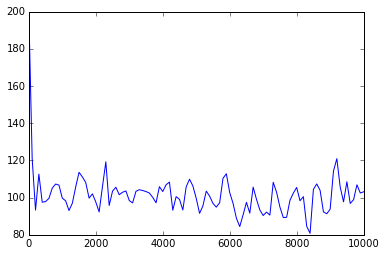

In [16]:
#print all thermo categories for the first simulation run
print "Thermo keywords = ", output.finds('thermo')[0].keys()
print

#Extract all step and temperature information
steps = output.finds('Step')
temps = output.finds('Temp')

#plot temps vs. steps
print "plot temperature vs. run step"
plt.plot(steps, temps)
plt.show()

### 5.2 atom_dump.load()

Resulting LAMMPS dump files can be read in with the atom_dump.load() function.  

More information on reading and writing atom dump files can be found in the [atomman.lammps.atom_dump Notebook](https://github.com/usnistgov/atomman/blob/master/Notebooks/atomman.lammps.atom_dump.ipynb).

In [17]:
system = lmp.atom_dump.load('10000.dump')
print system

avect =  [12.168,  0.000,  0.000]
bvect =  [ 0.000, 12.168,  0.000]
cvect =  [ 0.000,  0.000, 12.168]
origin = [-0.009, -0.009, -0.009]
natoms = 108
natypes = 1
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.438 |   0.467 |   0.374
      1 |       1 |   2.355 |   2.485 |   0.338
      2 |       1 |   2.427 |   0.246 |   2.434
      3 |       1 |   0.466 |   2.504 |   2.421
      4 |       1 |   4.440 |   0.476 |   0.395
      5 |       1 |   6.509 |   2.457 |   0.421
      6 |       1 |   6.379 |   0.410 |   2.460
      7 |       1 |   4.430 |   2.422 |   2.363
      8 |       1 |   8.470 |   0.413 |   0.445
      9 |       1 |  10.464 |   2.445 |   0.401
     10 |       1 |  10.552 |   0.426 |   2.439
     11 |       1 |   8.497 |   2.384 |   2.441
     12 |       1 |   0.329 |   4.515 |   0.413
     13 |       1 |   2.359 |   6.536 |   0.377
     14 |       1 |   2.463 |   4.486 |   2.388
     15 |       1 |   0.444 |   6.460 |   2.423
     16 |       1 |   4

## 6. Summary

This section collects all of the atomman.lammps functions associated with the demonstration, and reruns the simulation.

In [18]:
#load Potential
with open('MEAM-Al-Si-Mg-Cu-Fe.json') as meam_json:
    meam_potential = lmp.Potential(meam_json)
    
#setup system 
system_info = lmp.sys_gen(ucell =      fcc_cell,
                          units =      meam_potential.units, 
                          atom_style = meam_potential.atom_style,
                          size =       [[0,3], [0,3], [0,3]]) 

#get pair_info
pair_info = meam_potential.pair_info('AlS')

#create input script
with open('nvt.in', 'w') as inscript:    
    inscript.write( npt_script(system_info, pair_info, temperature=100.0) )

#run LAMMPS
output = lmp.run(lammps_exe, 'nvt.in')    

#read in final system info from dump file
system = lmp.atom_dump.load('10000.dump')

__File Cleanup__

In [19]:
os.remove('log.lammps')
os.remove('atom.dat')
os.remove('Jelinek_2012_meam.alsimgcufe')
os.remove('Jelinek_2012_meamf')
os.remove('MEAM-Al-Si-Mg-Cu-Fe.json')
os.remove('nvt.in')
os.remove('10000.dump.json')

#remove dump files
flist = os.listdir(os.getcwd())
for fname in flist:
    if fname[-5:] == '.dump':
        os.remove(fname)       